In [1]:
import os
import numpy as np
import pandas as pd
import json
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import keras
import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import *
import keras.backend as K
import keras.optimizers as Optimizers
import keras.callbacks
from keras.utils import to_categorical

Using TensorFlow backend.


In [2]:
data_path = "data"
labels_file = "bboxes.json"
img_size = (128, 128, 3)

In [3]:
colors = [(255, 0, 0),
           (0, 0, 255),
           (0, 255, 0),
           (0, 255, 255),
           (0, 102, 0),
           (255, 0, 255),
           (255, 255, 0),
           (255, 102, 255),
           (0, 51, 102),
           (51, 153, 255)]

In [4]:
class_nb = 2
nb_boxes = 1
grid_w = 7
grid_h = 7
cell_w = img_size[0] // grid_w
cell_h = img_size[1] // grid_h
img_w = grid_w * cell_w
img_h = grid_h * cell_h

In [5]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, data, data_path, class_nb, batch_size=32, shuffle=False, preprocess=None):
        super().__init__()
        self.data = data
        self.file_names = np.array(list(self.data.keys()))
        self.class_nb = class_nb
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.preprocess = preprocess
        self.data_path = data_path
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.data) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def preprocess(X):
        return X
    
    def __getitem__(self, index):
        X = np.empty((self.batch_size, img_size[1], img_size[0], img_size[2]), dtype=np.float32)
        y = np.empty((self.batch_size, grid_w * grid_h, (class_nb + nb_boxes * 5)), dtype=np.float32)
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        for i, f in enumerate([self.file_names[idx] for idx in indexes]):
            X[i,] = Image.open(os.path.join(self.data_path, f)).resize((img_size[0], img_size[1]))
            X[i,] = np.array(X[i,]) / 255.0
            y[i,] = build_yolo_out(self.data[f])
        if self.preprocess!=None: 
            X = self.preprocess(X)
        return X, y

In [6]:
def rect_is_in_cell(rect, row, col):
    if rect[0] * img_w > col * cell_w and rect[0] * img_w <= col * cell_w + cell_w and \
        rect[1] * img_h > row * cell_h and rect[1] * img_h <= row * cell_h + cell_h:
            return True
    return False

def build_yolo_out(data):
    y_t = []
    for row in range(grid_h):
        for col in range(grid_w):
            found = False
            for class_id in data:
                for rect in data[class_id]:
                    if rect_is_in_cell(rect, row, col):
                        #class
                        c_t = list(to_categorical(int(class_id)+1, num_classes=class_nb))
                        #define center position and w h
                        x = rect[0] * img_w
                        y = rect[1] * img_h
                        rel_x = (x - (col * cell_w)) / cell_w
                        rel_y = (y - (row * cell_h)) / cell_h
                        [x, y, w, h] = [rel_x, rel_y, rect[2], rect[3]]
                        #confidence
                        conf_t = [1]
                        elt = []
                        elt += c_t
                        for b in range(nb_boxes):
                            elt += [x, y, w, h] + conf_t
                        y_t.append(elt)
                        found = True
            if found == False:
                #class
                c_t = list(to_categorical(0, num_classes=class_nb))
                #define center position and w h
                rel_x = (cell_w / 2) / cell_w
                rel_y = (cell_h / 2) / cell_h
                [x, y, w, h] = [rel_x, rel_y, cell_w / img_w, cell_h / img_h]
                #confidence
                conf_t = [0]
                elt = []
                elt += c_t
                for b in range(nb_boxes):
                    elt += [x, y, w, h] + conf_t
                y_t.append(elt)
            
    return y_t

In [7]:
with open(labels_file) as f:
    dict_data = json.load(f)
                
batch_size = 1
train_batches = DataGenerator(dict_data, data_path, class_nb, batch_size=batch_size)

c:\users\rock_\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


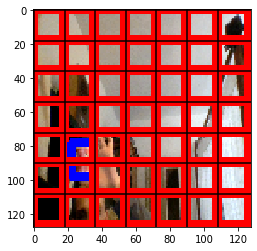

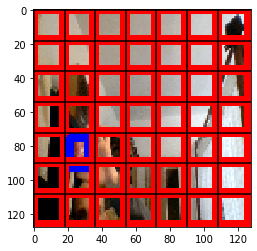

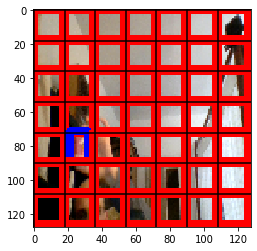

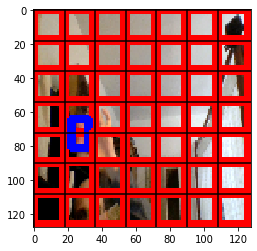

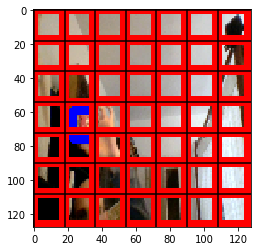

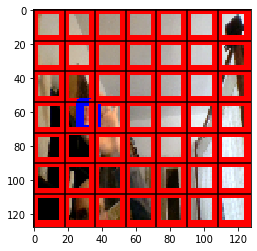

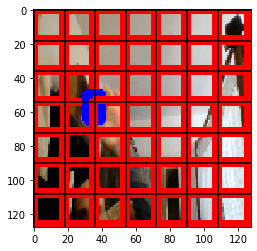

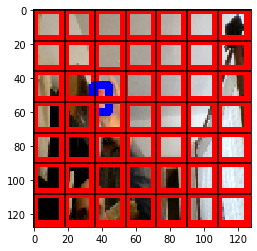

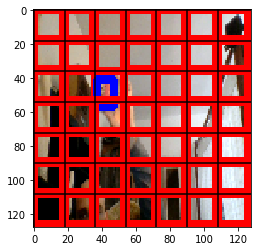

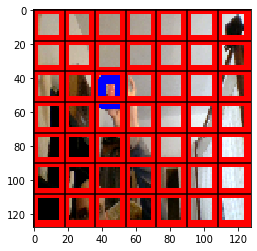

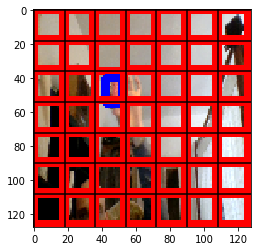

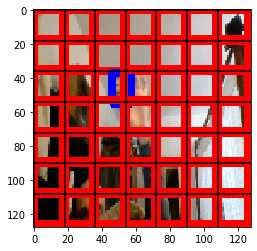

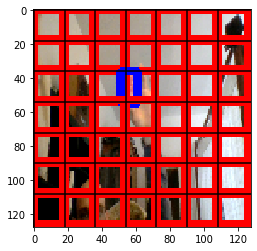

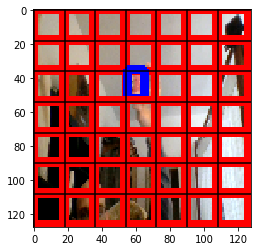

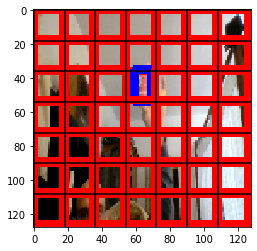

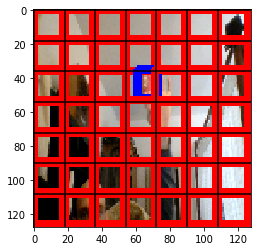

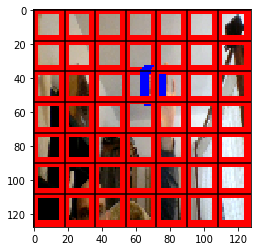

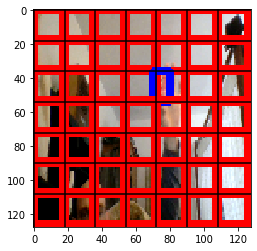

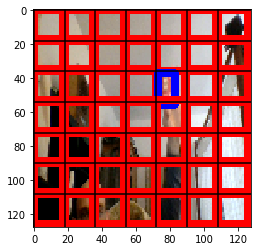

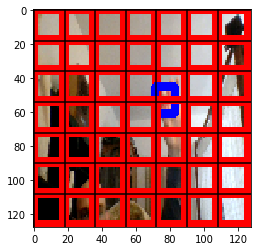

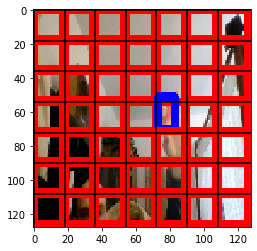

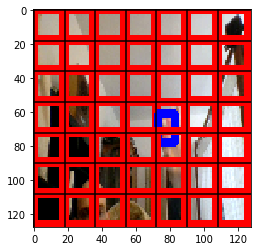

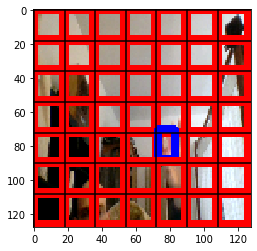

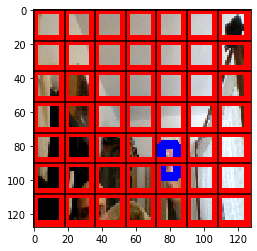

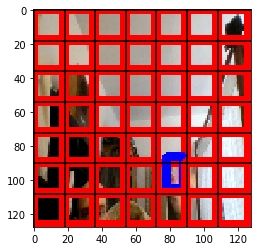

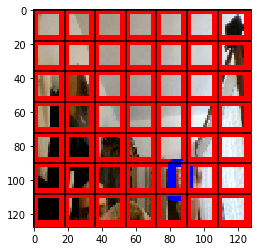

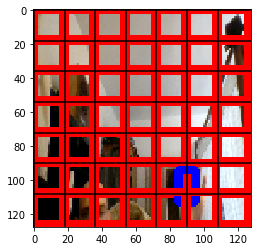

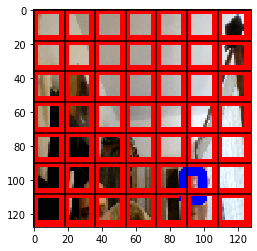

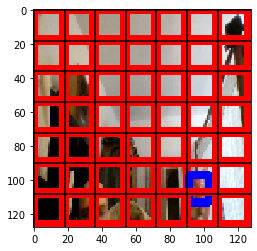

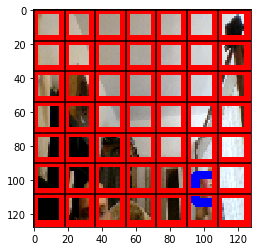

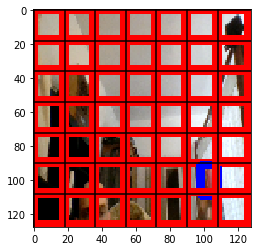

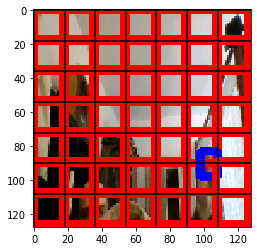

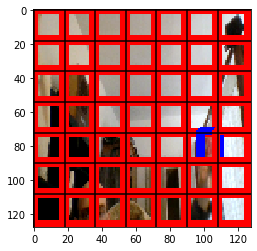

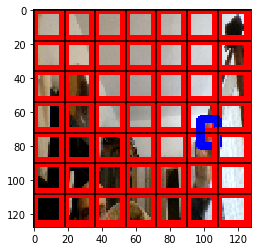

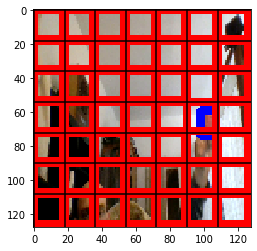

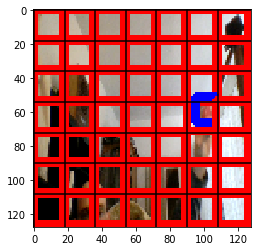

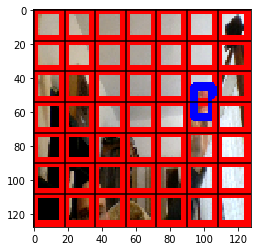

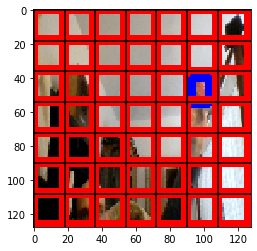

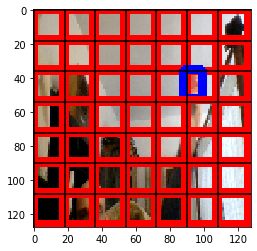

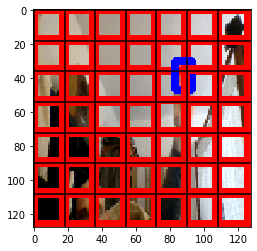

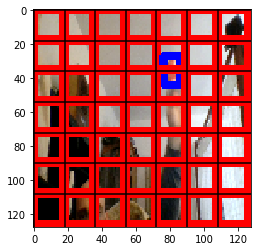

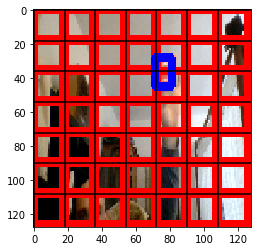

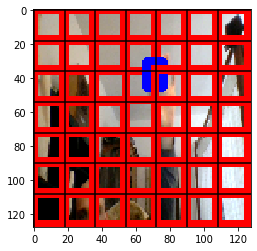

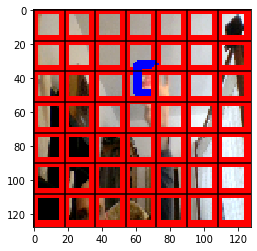

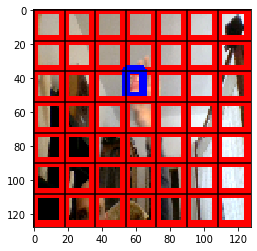

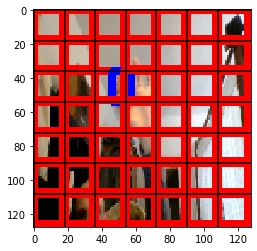

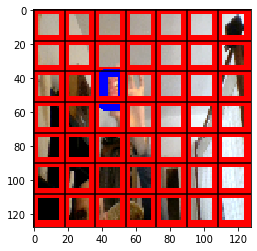

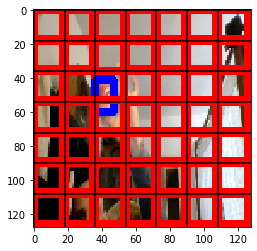

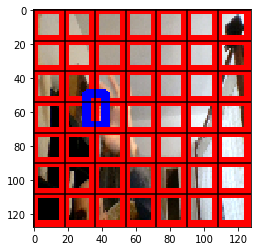

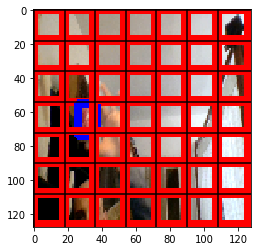

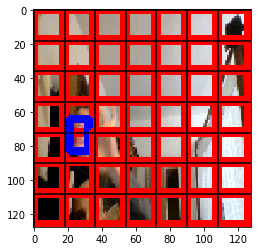

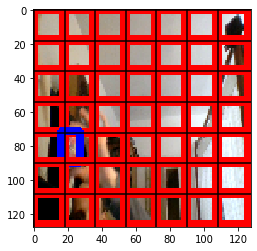

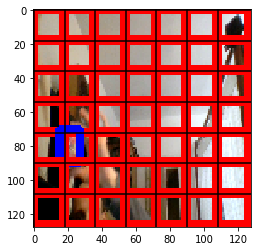

In [8]:
for batch in train_batches:
    for i in range(batch_size):
        img = (batch[0][i,] * 255).astype('uint8')
        for n, label in enumerate(batch[1][i,]):
            row = int((n / nb_boxes) / grid_h)
            col = (n / nb_boxes) - (row * grid_w)
            x = (label[class_nb + 0] * cell_w) + (col * cell_w)
            y = (label[class_nb + 1] * cell_h) + (row * cell_h) 
            pt1 = (int(x - (label[class_nb + 2] * img_w / 2)), \
                   int(y - (label[class_nb + 3] * img_h / 2)))
            pt2 = (int(x + (label[class_nb + 2] * img_w / 2)), \
                   int(y + (label[class_nb + 3] * img_h / 2)))
            cv2.rectangle(img, pt1, pt2, colors[np.argmax(label[:class_nb])], thickness=3)
        plt.figure()
        plt.imshow(img)
        for row in range(grid_w):
            plt.axvline(x=row*cell_w,color='black')
        for col in range(grid_h):
            plt.axhline(y=col*cell_h,color='black')

In [30]:
def custom_loss(y_true, y_pred):

    y_true_class = y_true[...,1:class_nb]
    y_pred_class = y_pred[...,1:class_nb]

    pred_boxes = K.reshape(y_pred[...,class_nb:], (-1, grid_w * grid_h, nb_boxes, 5))
    true_boxes = K.reshape(y_true[...,class_nb:], (-1, grid_w * grid_h, nb_boxes, 5))
    
    y_pred_xy   = pred_boxes[...,0:2]
    y_pred_wh   = pred_boxes[...,2:4]
    y_pred_conf = pred_boxes[...,4]

    y_true_xy   = true_boxes[...,0:2]
    y_true_wh   = true_boxes[...,2:4]
    y_true_conf = true_boxes[...,4]

    clss_loss  = K.sum(K.square(y_true_class - y_pred_class), axis=-1)
    xy_loss    = K.sum(K.sum(K.square(y_true_xy - y_pred_xy),axis=-1)*y_true_conf, axis=-1)
    wh_loss    = K.sum(K.sum(K.square(K.sqrt(y_true_wh) - K.sqrt(y_pred_wh)), axis=-1)*y_true_conf, axis=-1)

    # when we add the confidence the box prediction lower in quality but we gain the estimation of the quality of the box
    # however the training is a bit unstable

    # minimum distance between boxes distance between the two center
    intersect_wh = K.maximum(K.zeros_like(y_pred_wh), (y_pred_wh + y_true_wh)/2 - K.abs(y_pred_xy - y_true_xy) )
    intersect_area = intersect_wh[...,0] * intersect_wh[...,1]
    true_area = y_true_wh[...,0] * y_true_wh[...,1]
    pred_area = y_pred_wh[...,0] * y_pred_wh[...,1]
    union_area = pred_area + true_area - intersect_area
    iou = intersect_area / union_area

    conf_loss = K.sum(K.square(y_true_conf*iou - y_pred_conf)*y_true_conf, axis=-1)

    return clss_loss + xy_loss + wh_loss + conf_loss

In [61]:
K.clear_session()

img_in = Input(shape=(img_size[1], img_size[0], img_size[2]), name='img_in')

x = Conv2D(16, 1, padding='same')(img_in)
x = Conv2D(32, 3, padding='same')(x)
x = keras.layers.LeakyReLU(alpha=0.3)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)

x = Conv2D(16, 1, padding='same')(x)
x = Conv2D(32, 3, padding='same')(x)
x = keras.layers.LeakyReLU(alpha=0.3)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)

x = Conv2D(32, 1, padding='same')(x)
x = Conv2D(64, 3, padding='same')(x)
x = Conv2D(64, 1, padding='same')(x)
x = keras.layers.LeakyReLU(alpha=0.3)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)

x = Flatten()(x)
x = Dense(256, activation='sigmoid')(x)
x = Dense(grid_w * grid_h * (class_nb + nb_boxes * 5), activation='sigmoid')(x)
out = Reshape((grid_w * grid_h, (class_nb + nb_boxes * 5)))(x)

model = Model(inputs=img_in, outputs=out)

model.compile(optimizer = "adadelta", loss = custom_loss)

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img_in (InputLayer)          (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 16)      64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 16)        528 

In [62]:
model_name = "model.h5"
#save best model if model improved
best_checkpoint = keras.callbacks.ModelCheckpoint(model_name, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [63]:
idx = int(0.8*len(dict_data))
train_data = {k: dict_data[k] for k in list(dict_data)[:idx]}
val_data = {k: dict_data[k] for k in list(dict_data)[idx:]}

batch_size = 1
train_batches = DataGenerator(train_data, data_path, class_nb, batch_size=batch_size, shuffle=True)
val_batches = DataGenerator(val_data, data_path, class_nb, batch_size=batch_size)

history = model.fit_generator(train_batches, validation_data = val_batches, epochs = 50, verbose=1, callbacks=[best_checkpoint])

Epoch 1/50
42/42 [==============================] - 6s 137ms/step - loss: 0.0534 - val_loss: 0.1050

Epoch 00001: val_loss improved from inf to 0.10498, saving model to model.h5
Epoch 2/50
42/42 [==============================] - 5s 116ms/step - loss: 0.0276 - val_loss: 0.0848

Epoch 00002: val_loss improved from 0.10498 to 0.08485, saving model to model.h5
Epoch 3/50
42/42 [==============================] - 5s 120ms/step - loss: 0.0243 - val_loss: 0.0710

Epoch 00003: val_loss improved from 0.08485 to 0.07100, saving model to model.h5
Epoch 4/50
42/42 [==============================] - 5s 120ms/step - loss: 0.0230 - val_loss: 0.0568

Epoch 00004: val_loss improved from 0.07100 to 0.05681, saving model to model.h5
Epoch 5/50
42/42 [==============================] - 5s 122ms/step - loss: 0.0223 - val_loss: 0.0437

Epoch 00005: val_loss improved from 0.05681 to 0.04372, saving model to model.h5
Epoch 6/50
42/42 [==============================] - 5s 119ms/step - loss: 0.0220 - val_loss: 0

42/42 [==============================] - 5s 128ms/step - loss: 0.0014 - val_loss: 0.0043

Epoch 00050: val_loss did not improve from 0.00338


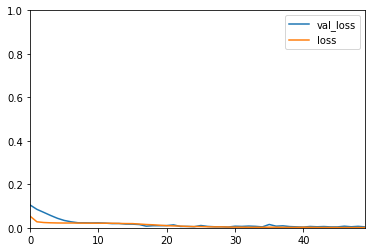

In [64]:
#print History graph
historydf = pd.DataFrame(history.history, index=history.epoch)
historydf.plot(ylim=(0,1))

[0.4352181  0.01269031 0.7690271  0.39547133 0.6662184  0.43706787
 0.73785174]
[0.3861143  0.01010767 0.51694816 0.3731885  0.72157717 0.66213095
 0.5480141 ]
[0.47320578 0.00691655 0.2865977  0.5691217  0.5796452  0.71240807
 0.25082844]
[0.65147215 0.01024315 0.49194875 0.6310948  0.5476863  0.5848415
 0.5470737 ]
[0.64820665 0.00843468 0.31103656 0.29059845 0.50785524 0.45375752
 0.41186103]
[0.38661057 0.01271391 0.45202616 0.6226816  0.4310813  0.21200213
 0.5935699 ]
[0.7155667  0.00783622 0.7368573  0.3032465  0.46756214 0.5511166
 0.46248013]
[0.59598345 0.00681669 0.37660465 0.63578194 0.24837369 0.6085197
 0.61470485]
[0.27216968 0.00871047 0.64121664 0.5967367  0.32755515 0.51000434
 0.63096035]
[0.41644195 0.01083621 0.5313976  0.6896152  0.6431813  0.31646335
 0.5467184 ]
[0.7740483  0.01104733 0.6918825  0.49689087 0.54841316 0.5008145
 0.48704016]
[0.2863244  0.03702116 0.60235876 0.84212923 0.09225482 0.21697581
 0.2103534 ]
[0.60424316 0.00980589 0.63607156 0.5114664 

 0.37905595]
[0.24952453 0.02194268 0.52961075 0.9019804  0.083929   0.2991274
 0.15579039]
[0.53680444 0.01012239 0.7100717  0.43866667 0.23130274 0.51678765
 0.6779921 ]
[0.23385999 0.008751   0.58952934 0.7552449  0.5941319  0.5654299
 0.6648992 ]
[0.49162984 0.00962627 0.29832807 0.46659184 0.66507655 0.45184907
 0.28097337]
[0.5793937  0.00839403 0.5683509  0.5889622  0.65800774 0.42540297
 0.5955813 ]
[0.33203232 0.82529867 0.71977544 0.6168983  0.07962528 0.13352376
 0.04101658]
[0.6195585  0.14882329 0.19446534 0.55103445 0.11953253 0.13390875
 0.04609582]
[0.3841275  0.00990197 0.22340369 0.5118078  0.09943768 0.0422326
 0.06904387]
[0.5525114  0.01495489 0.4879639  0.4801352  0.07987815 0.20697278
 0.08426276]
[0.5343529  0.0060845  0.2653512  0.26103896 0.5461571  0.36649168
 0.35722095]
[0.48214462 0.00775278 0.21974164 0.4421394  0.39974415 0.35812652
 0.62387633]
[0.3231035  0.00762862 0.8601238  0.44734338 0.14884004 0.12613001
 0.08045369]
[0.51972854 0.0066703  0.46432

 0.41300556]
[0.60800546 0.01152223 0.6166403  0.7228395  0.6523453  0.30237108
 0.4709551 ]
[0.4220495  0.03274539 0.50879663 0.9369066  0.12052402 0.19488823
 0.15397397]
[0.5574118  0.00639531 0.5472674  0.4775512  0.17405272 0.22563788
 0.5770618 ]
[0.32919356 0.00770703 0.6916574  0.6762227  0.78314936 0.7421133
 0.68223566]
[0.5723582  0.0033201  0.42110872 0.34822804 0.51996076 0.58903325
 0.47270802]
[0.70308983 0.01447064 0.4136952  0.47244355 0.7668463  0.37366495
 0.46441847]
[0.3238721  0.17613968 0.24487844 0.7476479  0.04708236 0.15168399
 0.07558462]
[0.52994514 0.0103741  0.6493692  0.20434171 0.12988362 0.167294
 0.02541229]
[0.42544582 0.0086368  0.18350846 0.5671042  0.08294237 0.06667525
 0.04637653]
[0.60480326 0.02431324 0.46160004 0.37408042 0.07851413 0.16837093
 0.12079769]
[0.36304334 0.00687432 0.46944007 0.2586009  0.35551524 0.5505903
 0.47690314]
[0.5005326  0.0055742  0.20268166 0.4109363  0.26413143 0.17548409
 0.67611754]
[0.4182465  0.73242974 0.926333

 0.51188236]
[0.36723948 0.01579165 0.53887767 0.7843818  0.16877031 0.27739555
 0.15032616]
[0.55013114 0.0059768  0.7085867  0.5194277  0.27893376 0.3088007
 0.47629815]
[0.42716226 0.01010349 0.65636694 0.4151753  0.48447832 0.7062061
 0.6517531 ]
[0.6408096  0.00890788 0.3445006  0.27718306 0.71884    0.68673694
 0.5872749 ]
[0.5367049  0.01069936 0.4692502  0.5140599  0.62463975 0.19343612
 0.5060076 ]
[0.37386352 0.010708   0.4405243  0.6444069  0.06643438 0.17597374
 0.10508174]
[0.2863714  0.01455718 0.5892802  0.33471113 0.09329015 0.1201995
 0.03017065]
[0.41971985 0.02650017 0.23986867 0.46812227 0.09466729 0.06028372
 0.02659282]
[0.5667611  0.01769325 0.22134265 0.33754763 0.08952877 0.17605701
 0.06742233]
[0.57279253 0.007294   0.32560253 0.26106358 0.34803617 0.44271597
 0.33082044]
[0.41679004 0.00588197 0.25242305 0.4977872  0.39363733 0.28390706
 0.7204417 ]
[0.48868346 0.01800391 0.70827675 0.6724408  0.13392529 0.11168382
 0.03595597]
[0.4019897  0.00863346 0.27977

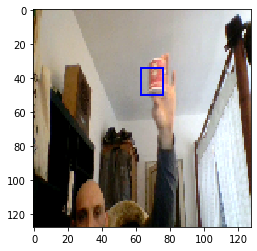

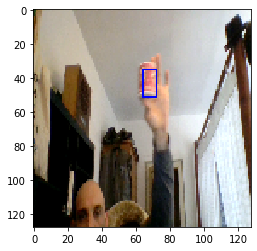

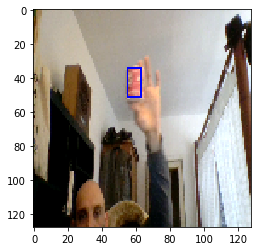

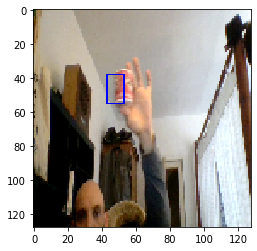

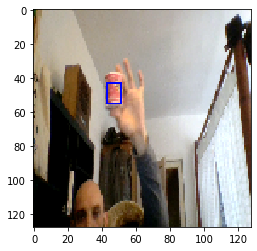

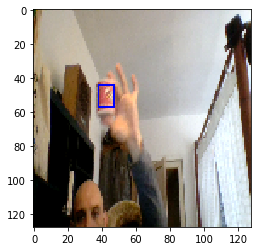

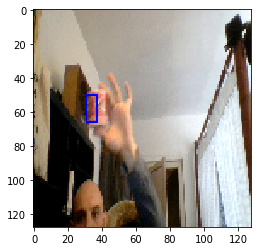

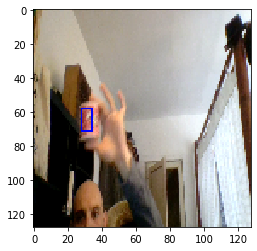

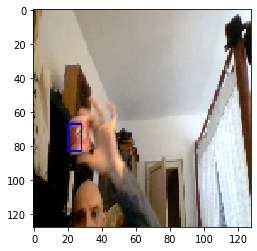

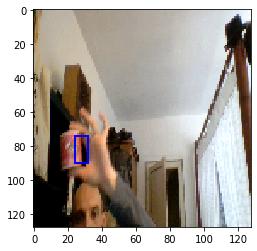

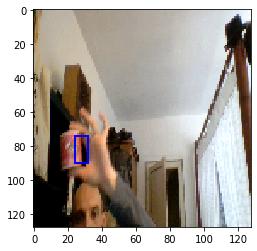

In [66]:
for batch in val_batches:
    for i in range(batch_size):
        img = batch[0][i,]
        pred = model.predict(img.reshape((1, img_size[1], img_size[0], img_size[2])))
        img = (img * 255).astype('uint8')
        for n, label in enumerate(pred[0]):
            print(label)
            row = int((n / nb_boxes) / grid_h)
            col = (n / nb_boxes) - (row * grid_w)
            x = (label[class_nb + 0] * cell_w) + (col * cell_w)
            y = (label[class_nb + 1] * cell_h) + (row * cell_h)
            pt1 = (int(x - (label[class_nb + 2] * img_w / 2)), \
                   int(y - (label[class_nb + 3] * img_h / 2)))
            pt2 = (int(x + (label[class_nb + 2] * img_w / 2)), \
                   int(y + (label[class_nb + 3] * img_h / 2)))
            cls = np.argmax(label[:class_nb])
            if cls:
                cv2.rectangle(img, pt1, pt2, colors[cls])
        plt.figure()
        plt.imshow(img)